In [2]:
# Uncomment the below line of code if you want to try TensorFlow v2.0
#!pip install tf-nightly-gpu-2.0-preview

In [5]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Dikesh\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [5]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

fatal: destination path 'examples' already exists and is not an empty directory.


In [6]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [7]:
# Download data and extract it to folder
get_data_extract()

Dataset already exists


In [8]:
# Check the extracted dataset folder
os.listdir('food-101/')

['.DS_Store',
 'images',
 'license_agreement.txt',
 'meta',
 'README.txt',
 'test',
 'test_mini',
 'train',
 'train_mini']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [9]:
os.listdir('food-101/images')

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [10]:
os.listdir('food-101/meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

# Visualize random image from each of the 101 classes

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

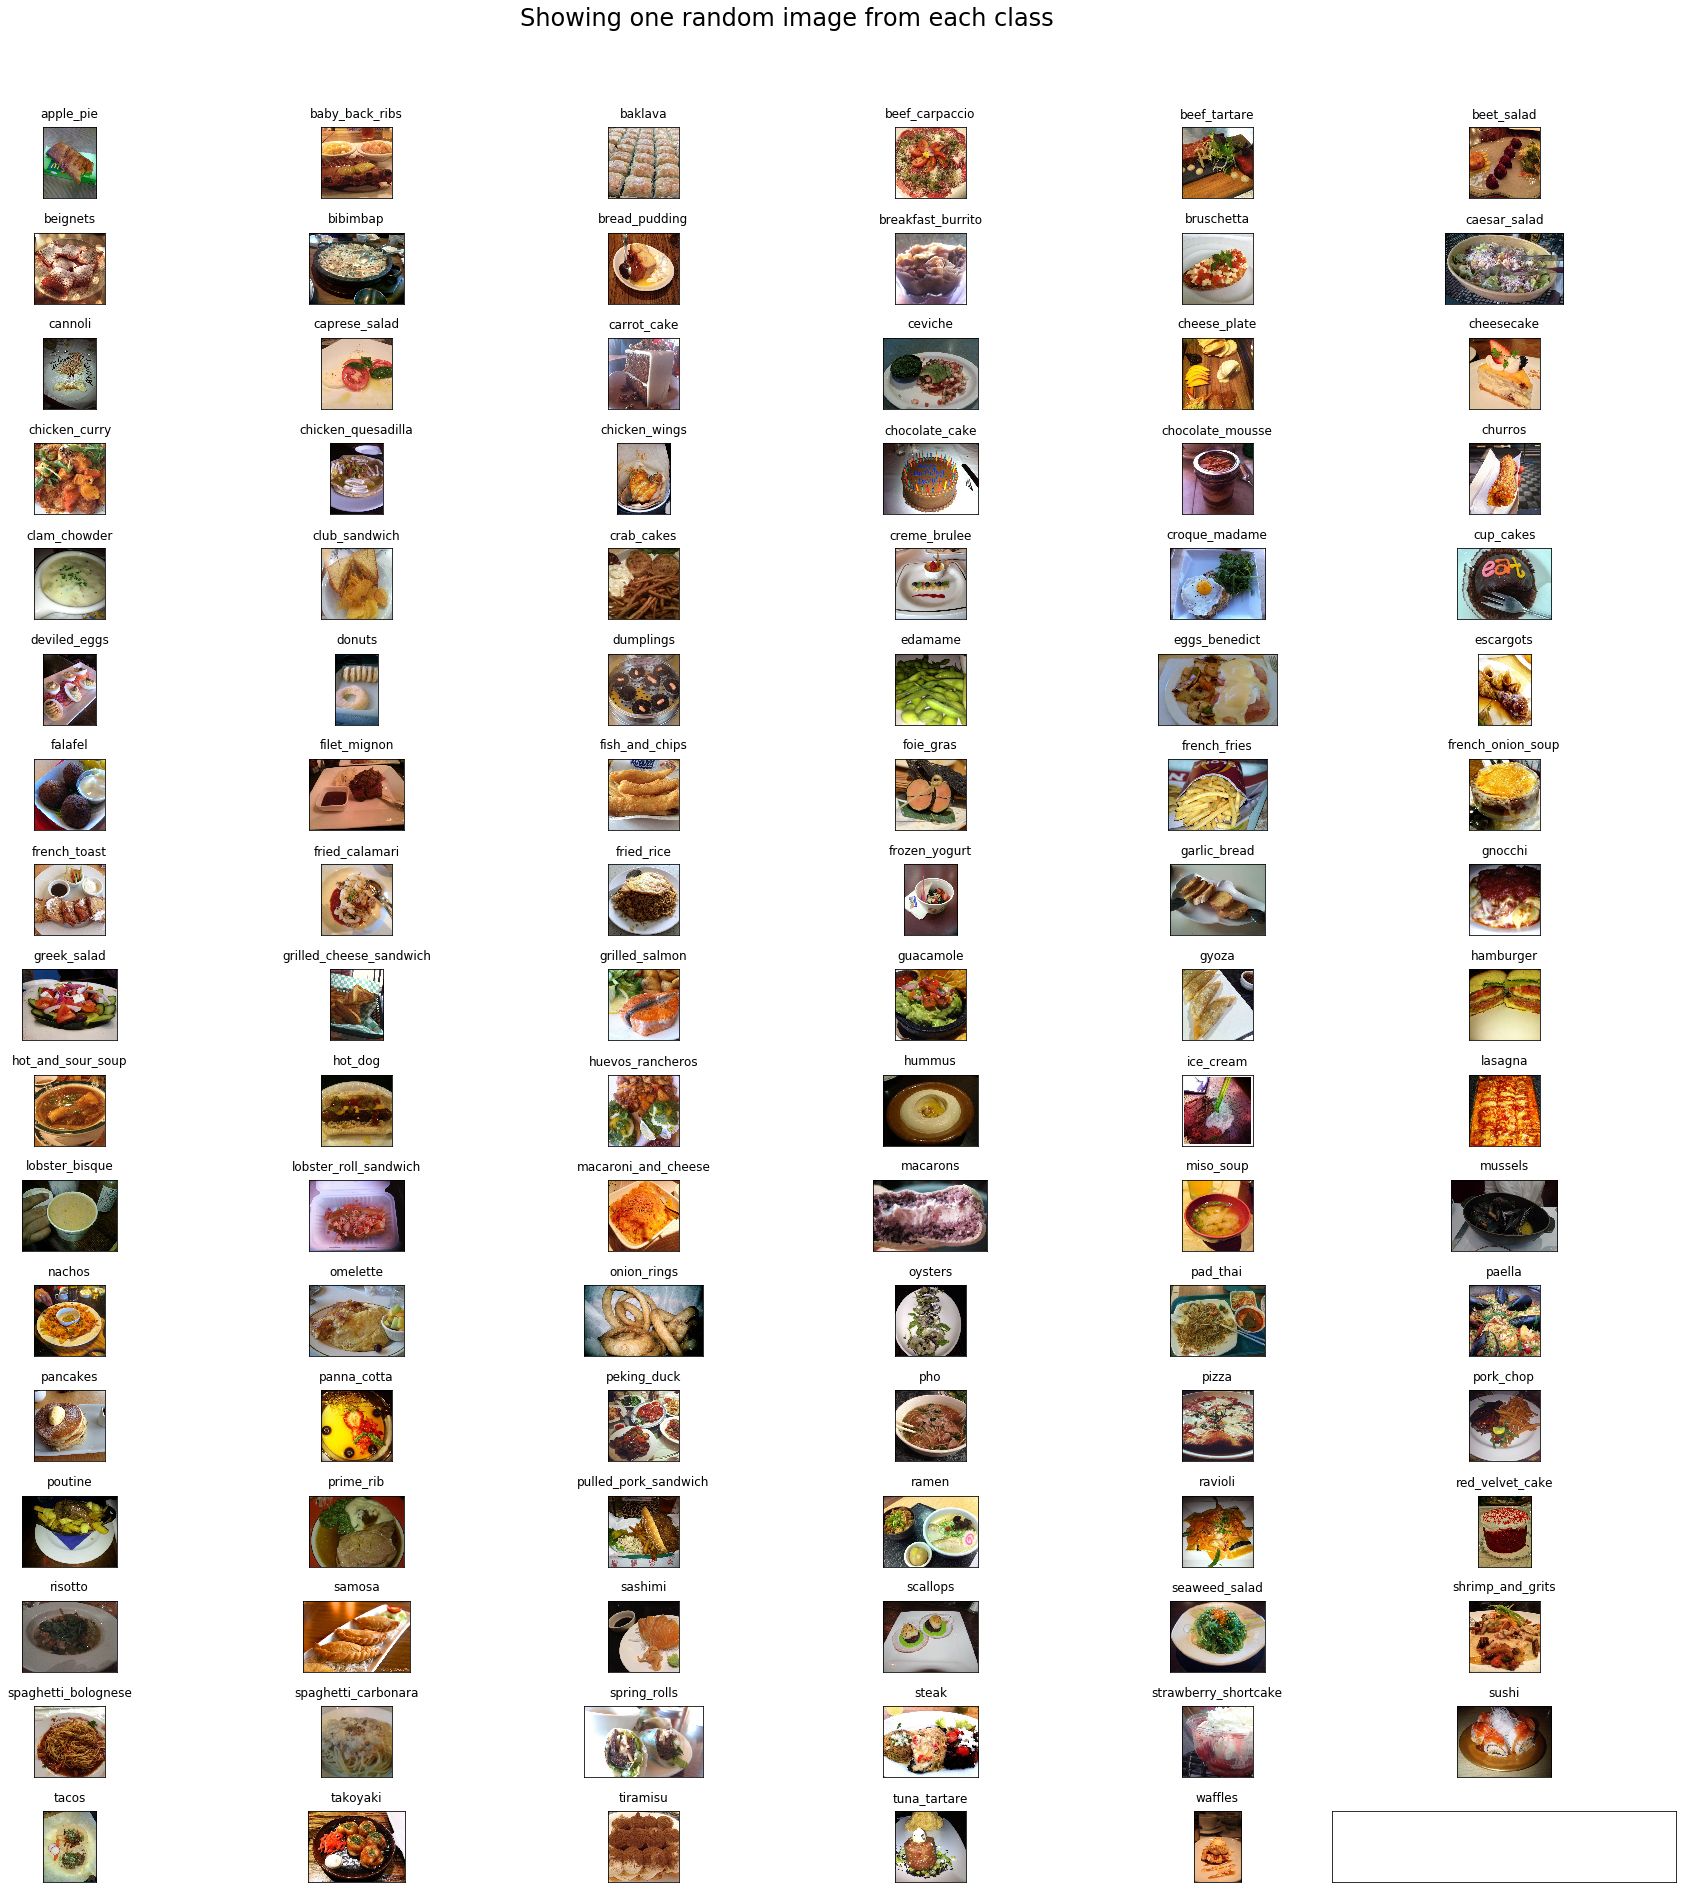

In [12]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [13]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [14]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [15]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [16]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [17]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [18]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [19]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [20]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette','dumplings','donuts','ramen','steak','sushi','waffles','hamburger']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [21]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette
Copying images into dumplings
Copying images into donuts
Copying images into ramen
Copying images into steak
Copying images into sushi
Copying images into waffles
Copying images into hamburger


In [22]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
7500


In [23]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette
Copying images into dumplings
Copying images into donuts
Copying images into ramen
Copying images into steak
Copying images into sushi
Copying images into waffles
Copying images into hamburger


In [24]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2500


# Fine tune Inception Pretrained model using Food 101 dataset

In [3]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [27]:
# Train the model with data from 3 classes
n_classes = 3
epochs = 10
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 468 steps, validate for 156 steps
Epoch 1/10
  1/468 [..............................] - ETA: 1:23:27WARNING:tensorflow:Can save best model only with val_loss available, skipping.


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[16,3] labels_size=[16,10]
	 [[node loss/dense_1_loss/softmax_cross_entropy_with_logits (defined at <ipython-input-25-434c5e5c5563>:52) ]] [Op:__inference_distributed_function_43937]

Function call stack:
distributed_function


# Visualize the accuracy and loss plots

In [14]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

NameError: name 'history' is not defined

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

In [8]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
  

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = 'C:/Users/Dikesh/Desktop/'
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'dum.jpg')
images.append(imagepath+'samosa.jpg')
images.append(imagepath+'omelette.jpg')
predict_class(model_best, images, True)

The model got them all right!

In [29]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  random.seed(9000)
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

In [12]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 101
food_list = sorted(os.listdir("food-101/images/"))
#pick_n_random_classes(11)

In [31]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into beef_carpaccio
Copying images into beef_tartare
Copying images into beet_salad
Copying images into beignets
Copying images into bibimbap
Copying images into bread_pudding
Copying images into breakfast_burrito
Copying images into bruschetta
Copying images into caesar_salad
Copying images into cannoli
Copying images into caprese_salad
Copying images into carrot_cake
Copying images into ceviche
Copying images into cheese_plate
Copying images into cheesecake
Copying images into chicken_curry
Copying images into chicken_quesadilla
Copying images into chicken_wings
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into churros
Copying images into clam_chowder
Copying images into club_sandwich
Copying images into crab_cakes
Copying images into creme_brulee
Copying images into croque_madame
Copyin

In [32]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
75750


In [33]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into beef_carpaccio
Copying images into beef_tartare
Copying images into beet_salad
Copying images into beignets
Copying images into bibimbap
Copying images into bread_pudding
Copying images into breakfast_burrito
Copying images into bruschetta
Copying images into caesar_salad
Copying images into cannoli
Copying images into caprese_salad
Copying images into carrot_cake
Copying images into ceviche
Copying images into cheese_plate
Copying images into cheesecake
Copying images into chicken_curry
Copying images into chicken_quesadilla
Copying images into chicken_wings
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into churros
Copying images into clam_chowder
Copying images into club_sandwich
Copying images into crab_cakes
Copying images into creme_brulee
Copying images into croque_madame
Copying image

In [34]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
25250


In [ ]:
# Train the model with data from 3 classes
n_classes = 101
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_11 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_11)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4734 steps, validate for 1578 steps
Epoch 1/30
4733/4734 [============================>.] - ETA: 0s - loss: 4.7728 - accuracy: 0.1087
Epoch 00001: val_loss improved from inf to 3.71002, saving model to bestmodel_101class.hdf5
4734/4734 [==============================] - 2113s 446ms/step - loss: 4.7725 - accuracy: 0.1088 - val_loss: 3.7100 - val_accuracy: 0.3463
Epoch 2/30
4733/4734 [============================>.] - ETA: 0s - loss: 3.4717 - accuracy: 0.3404
Epoch 00002: val_loss improved from 3.71002 to 2.39021, saving model to bestmodel_101class.hdf5
4734/4734 [==============================] - 2004s 423ms/step - loss: 3.4715 - accuracy: 0.3404 - val_loss: 2.3902 - val_accuracy: 0.5594
Epoch 3/30
4733/4734 [============================>.] - ETA: 0s - loss: 2.7215 - accuracy: 0.4694
Epoch 00003: val_loss improved from 2.39021 to 1.88905, 

In [1]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

NameError: name 'history' is not defined

In [6]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_101class.hdf5',compile = False)

Wall time: 5.06 s


In [3]:
scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

IndentationError: unexpected indent (<ipython-input-3-f2c535b7f961>, line 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


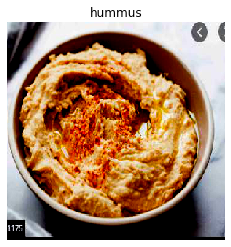

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


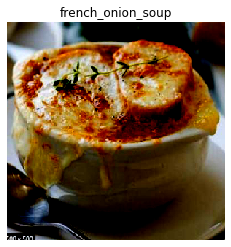

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


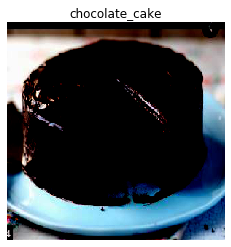

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


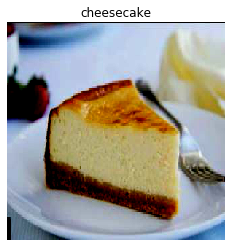

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


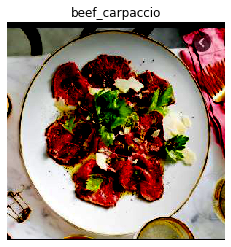

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


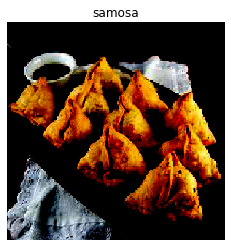

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


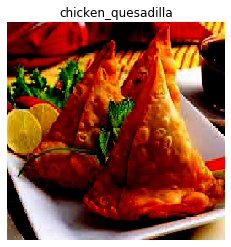

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


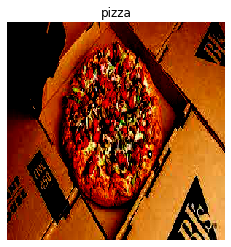

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


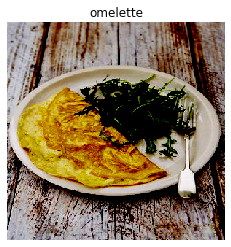

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


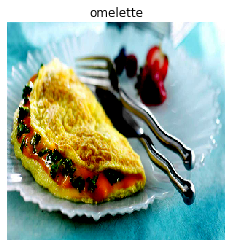

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


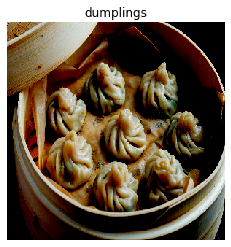

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


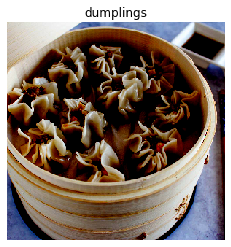

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


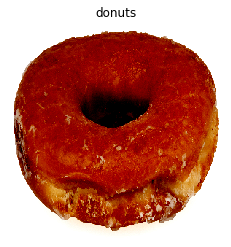

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


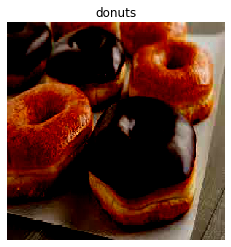

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


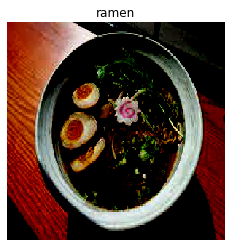

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


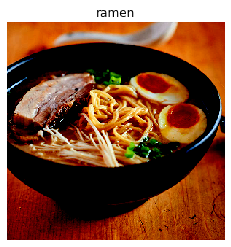

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


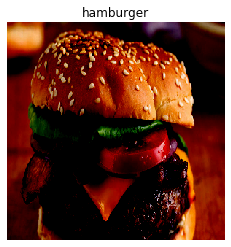

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


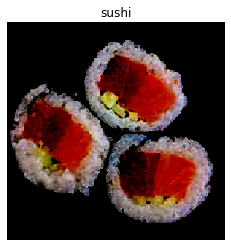

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


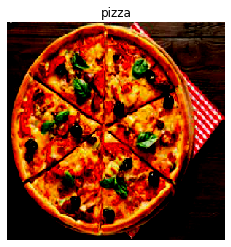

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


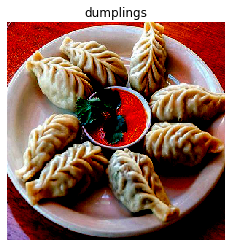

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


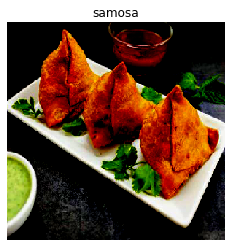

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


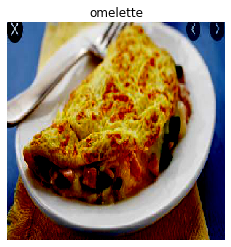

In [13]:
# Make a list of downloaded images and test the trained model
images = []
imagepath = 'C:/Users/Dikesh/Desktop/pictures/'
images.append(imagepath+'1.jpg')
images.append(imagepath+'2.jpg')
images.append(imagepath+'3.jpg')
images.append(imagepath+'4.jpg')
images.append(imagepath+'5.jpg')
images.append(imagepath+'6.jpg')
images.append(imagepath+'7.jpg')
images.append(imagepath+'8.jpg')
images.append(imagepath+'9.jpg')
images.append(imagepath+'10.jpg')
images.append(imagepath+'11.jpg')
images.append(imagepath+'12.jpg')
images.append(imagepath+'13.jpg')
images.append(imagepath+'14.jpg')
images.append(imagepath+'15.jpg')
images.append(imagepath+'16.jpg')
images.append(imagepath+'17.jpg')
images.append(imagepath+'18.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'dum.jpg')
images.append(imagepath+'samosa.jpg')
images.append(imagepath+'omelette.jpg')
predict_class(model_best, images, True)